Below is the code for offline image segmentation without adverserial (minimisation problem and not minimax). The below examples are not included in the draft.

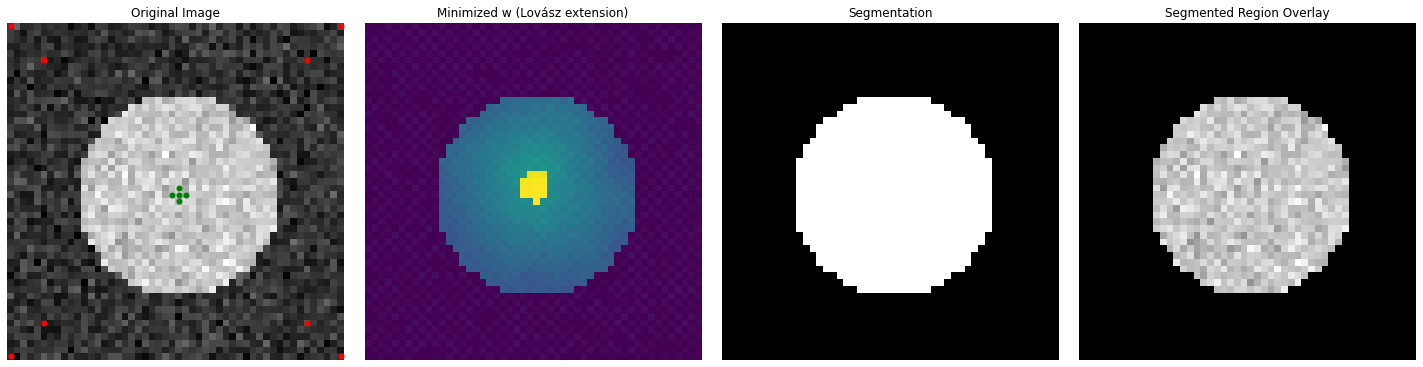

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Create a simple 50x50 grayscale image with a circle in the center
height, width = 50, 50
image = np.zeros((height, width))
center_x, center_y = 25, 25
radius = 15
for i in range(height):
    for j in range(width):
        if (i - center_x)**2 + (j - center_y)**2 < radius**2:
            image[i, j] = 200
        else:
            image[i, j] = 50

# Add Gaussian noise
noise =  np.random.normal(0, 20, (height, width))
image += noise
image = np.clip(image, 0, 255)

# Define seeds for foreground (1) and background (0)
fg_seeds = [(25, 25), (24, 25), (25, 24), (25, 26), (26, 25)]  # Around center
bg_seeds = [(0, 0), (0, 49), (49, 0), (49, 49), (5, 5), (5, 44), (44, 5), (44, 44)]  # Around borders

# Flatten image to 1D for optimization
n_pixels = height * width
seeds_dict = {}
for pos in fg_seeds:
    idx = pos[0] * width + pos[1]
    seeds_dict[idx] = 1.0
for pos in bg_seeds:
    idx = pos[0] * width + pos[1]
    seeds_dict[idx] = 0.0

# Define directed edges (both directions for 4-neighbors) and weights
sigma = 20  # Parameter for similarity
edges = []
for i in range(height):
    for j in range(width):
        idx = i * width + j
        # Right neighbor
        if j < width - 1:
            jdx = i * width + (j + 1)
            diff_sq = (image[i, j] - image[i, j + 1]) ** 2
            d = np.exp(-diff_sq / (2 * sigma ** 2))
            edges.append((idx, jdx, d))  # idx -> jdx
            edges.append((jdx, idx, d))  # jdx -> idx
        # Down neighbor
        if i < height - 1:
            jdx = (i + 1) * width + j
            diff_sq = (image[i, j] - image[i + 1, j]) ** 2
            d = np.exp(-diff_sq / (2 * sigma ** 2))
            edges.append((idx, jdx, d))  # idx -> jdx
            edges.append((jdx, idx, d))  # jdx -> idx

# Initialize w
w = np.zeros(n_pixels)
for idx, val in seeds_dict.items():
    w[idx] = val

# Subgradient descent parameters
n_iter = 10000
alpha0 = 0.01  # Initial learning rate

free_indices = set(range(n_pixels)) - set(seeds_dict.keys())

for it in range(n_iter):
    alpha = alpha0
    g = np.zeros(n_pixels)
    for fr, to, d in edges:
        x = w[fr] - w[to]
        if x > 0:
            g[fr] += d * 1
            g[to] += d * (-1)
        # For x <= 0, add 0 (choosing 0 in subdiff interval)
    # Update only free variables
    for i in free_indices:
        w[i] -= alpha * g[i]
    # Optional: clip to [0,1] for stability (though not strictly necessary)
    w = np.clip(w, 0, 1)
    # Re-enforce seeds (though not updated)
    for idx, val in seeds_dict.items():
        w[idx] = val

# After the optimization loop (after 'for it in range(n_iter):' block)

# Define the cut function F(A_bin)
def compute_F(A_bin):
    val = 0.0
    for fr, to, d_val in edges:
        if A_bin[fr] == 1 and A_bin[to] == 0:
            val += d_val
    return val

# Adapted round_solution for constrained case
def round_solution(w, F, fg_indices, bg_indices, free_indices):
    free_list = np.array(free_indices)
    free_order = np.argsort(-w[free_list])
    ordered_free = free_list[free_order]
    
    best_set = None
    best_val = float("inf")
    A_bin = np.zeros(len(w), dtype=int)
    
    # Base case: A = fg seeds only
    for idx in fg_indices:
        A_bin[idx] = 1
    val = F(A_bin)
    if val < best_val:
        best_val = val
        best_set = A_bin.copy()
    
    # Add free pixels cumulatively in descending order of w
    for m in range(1, len(free_indices) + 1):
        add_idx = ordered_free[m - 1]
        A_bin[add_idx] = 1
        val = F(A_bin)
        if val < best_val:
            best_val = val
            best_set = A_bin.copy()
    
    return best_set, best_val

# Collect indices
fg_indices = [idx for idx, val in seeds_dict.items() if val == 1.0]
bg_indices = [idx for idx, val in seeds_dict.items() if val == 0.0]
free_indices = list(set(range(n_pixels)) - set(seeds_dict.keys()))

# Recover the minimizer set
best_set, best_val = round_solution(w, compute_F, fg_indices, bg_indices, free_indices)

# For segmentation
seg = best_set.reshape((height, width)).astype(float)

# Plot results
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')
for pos in fg_seeds:
    axs[0].plot(pos[1], pos[0], 'go', markersize=5)  # Green for FG
for pos in bg_seeds:
    axs[0].plot(pos[1], pos[0], 'ro', markersize=5)  # Red for BG
axs[1].imshow(w.reshape((height, width)), cmap='viridis')
axs[1].set_title('Minimized w (Lovász extension)')
axs[2].imshow(seg, cmap='gray')
axs[2].set_title(f'Segmentation')
axs[3].imshow(image * seg, cmap='gray')
axs[3].set_title('Segmented Region Overlay')
for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:

# ---------- 1. Create a more complex image (happy face) ----------
def create_happy_face_image(h=100, w=100):
    img = np.ones((h, w)) * 40  # dark background
    cy, cx = h // 2, w // 2
    r_face = 30

    # Face disk
    y, x = np.ogrid[:h, :w]
    mask_face = (y - cy) ** 2 + (x - cx) ** 2 <= r_face ** 2
    img[mask_face] = 180  # bright face

    # Eyes (darker blobs)
    eye_offset_y = -10
    eye_offset_x = 12
    r_eye = 4
    mask_left_eye = (y - (cy + eye_offset_y)) ** 2 + (x - (cx - eye_offset_x)) ** 2 <= r_eye ** 2
    mask_right_eye = (y - (cy + eye_offset_y)) ** 2 + (x - (cx + eye_offset_x)) ** 2 <= r_eye ** 2
    img[mask_left_eye] = 60
    img[mask_right_eye] = 60

    # Mouth as an arc of darker pixels
    for t in np.linspace(-0.7, 0.7, 60):
        my = cy + 10 + int(10 * np.sin(t))
        mx = cx + int(15 * np.cos(t))
        if 0 <= my < h and 0 <= mx < w:
            img[my, mx] = 60

    # Add Gaussian noise
    noise = np.random.normal(0, 15, (h, w))
    img = np.clip(img + noise, 0, 255)
    return img

# ---------- 2. Lovász-extension subgradient + rounding (your method) ----------
def segment_with_lovasz(image, fg_seeds, bg_seeds, sigma_I=20, sigma_x = 1, n_iter=10000, alpha0=0.01):
    height, width = image.shape
    n_pixels = height * width

    # Build seeds dict
    seeds_dict = {}
    for pos in fg_seeds:
        idx = pos[0] * width + pos[1]
        seeds_dict[idx] = 1.0
    for pos in bg_seeds:
        idx = pos[0] * width + pos[1]
        seeds_dict[idx] = 0.0


    edges = []

    for i in range(height):
        for j in range(width):
            idx = i * width + j

            for di, dj in [(0,1), (1,0)]:  # 4-neighbours
                ni, nj = i + di, j + dj
                if ni < height and nj < width:
                    jdx = ni * width + nj

                    # spatial distance
                    dist_sq = di**2 + dj**2

                    # intensity distance
                    diff_sq = (image[i, j] - image[ni, nj])**2

                    # bilateral weight
                    d = np.exp(
                        -dist_sq / (2 * sigma_x**2)
                        -diff_sq / (2 * sigma_I**2)
                    )

                    edges.append((idx, jdx, d))
                    edges.append((jdx, idx, d))

    # Initialize w
    w = np.zeros(n_pixels)
    for idx, val in seeds_dict.items():
        w[idx] = val

    free_indices = set(range(n_pixels)) - set(seeds_dict.keys())

    # Subgradient descent on Lovász extension
    for it in range(n_iter):
        alpha = alpha0
        g = np.zeros(n_pixels)
        for fr, to, d in edges:
            x = w[fr] - w[to]
            if x > 0:
                g[fr] += d
                g[to] -= d
        # Update only free pixels
        for i in free_indices:
            w[i] -= alpha * g[i]
        w = np.clip(w, 0, 1)
        # Re-enforce seeds
        for idx, val in seeds_dict.items():
            w[idx] = val

    # Cut function
    def compute_F(A_bin):
        val = 0.0
        for fr, to, d_val in edges:
            if A_bin[fr] == 1 and A_bin[to] == 0:
                val += d_val
        return val

    # Rounding (respecting seeds)
    def round_solution(w, F, fg_indices, bg_indices, free_indices_list):
        free_list = np.array(free_indices_list)
        free_order = np.argsort(-w[free_list])
        ordered_free = free_list[free_order]

        best_set = None
        best_val = float("inf")
        A_bin = np.zeros(len(w), dtype=int)

        # base: only FG seeds in A
        for idx in fg_indices:
            A_bin[idx] = 1
        val = F(A_bin)
        if val < best_val:
            best_val = val
            best_set = A_bin.copy()

        # add free pixels in descending w
        for m in range(1, len(free_indices_list) + 1):
            add_idx = ordered_free[m - 1]
            A_bin[add_idx] = 1
            val = F(A_bin)
            if val < best_val:
                best_val = val
                best_set = A_bin.copy()
        return best_set, best_val

    fg_indices = [idx for idx, val in seeds_dict.items() if val == 1.0]
    bg_indices = [idx for idx, val in seeds_dict.items() if val == 0.0]
    free_indices_list = list(set(range(n_pixels)) - set(seeds_dict.keys()))

    best_set, best_val = round_solution(w, compute_F, fg_indices, bg_indices, free_indices_list)
    seg = best_set.reshape((height, width)).astype(float)
    return w.reshape((height, width)), seg

# ---------- 3. Use it on a “happy face over background” ----------
height, width =100, 100
image = create_happy_face_image(height, width)

# FG seeds inside the face
fg_seeds = [
    (50, 50), (45, 50), (55, 50),
    (50, 45), (50, 55)
]

# BG seeds in corners and far background
bg_seeds = [
    (2, 2), (2, 97), (97, 2), (97, 97),
    (10, 50), (90, 50)
]

w_map, seg = segment_with_lovasz(image, fg_seeds, bg_seeds,
                                 sigma_I=20,sigma_x=1, n_iter=11000, alpha0=0.01)




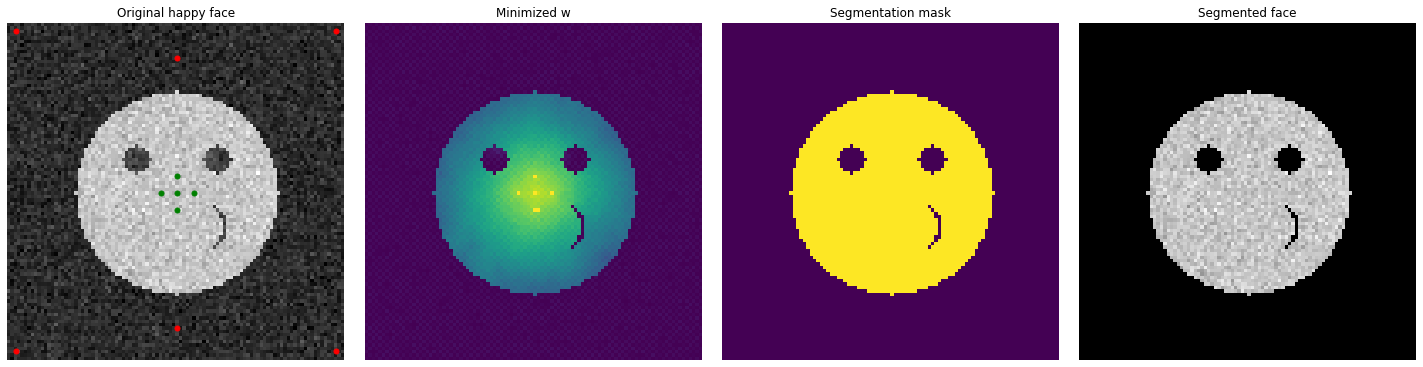

In [74]:
# ---------- 4. Visualize ----------
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original happy face')
for pos in fg_seeds:
    axs[0].plot(pos[1], pos[0], 'go', markersize=5)
for pos in bg_seeds:
    axs[0].plot(pos[1], pos[0], 'ro', markersize=5)

axs[1].imshow(w_map, cmap='viridis')
axs[1].set_title('Minimized w')

axs[2].imshow(seg, cmap='viridis')
axs[2].set_title('Segmentation mask')

axs[3].imshow(image * seg, cmap='gray')
axs[3].set_title('Segmented face')

for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

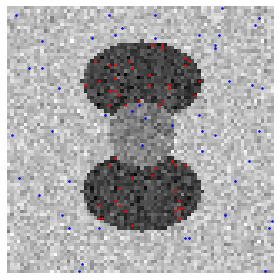

In [ ]:

H, W = 80, 80
img = np.ones((H, W)) * 120  # background

y, x = np.ogrid[:H, :W]

# top blob (dark gray)
mask_top = (y - 22)**2/12**2 + (x - 40)**2/18**2 <= 1
img[mask_top] = 60

# bottom blob (dark gray, shifted)
mask_bottom = (y - 55)**2/12**2 + (x - 40)**2/18**2 <= 1
img[mask_bottom] = 60

# center connector (mid gray)
mask_center = (y - 38)**2/10**2 + (x - 40)**2/10**2 <= 1
img[mask_center] = 90

# ---- choose seeds BEFORE noise ----
rng = np.random.default_rng()

# pixels with intensity 60
coords_60 = np.argwhere(img == 60)
# pixels with intensity 90 or 120
coords_90_120 = np.argwhere((img == 90) | (img == 120))

# choose 30 seeds from each group
n_fg = 50
n_bg = 50

fg_indices = rng.choice(len(coords_60), size=n_fg, replace=False)
bg_indices = rng.choice(len(coords_90_120), size=n_bg, replace=False)

fg_seeds = [(int(r), int(c)) for r, c in coords_60[fg_indices]]
bg_seeds = [(int(r), int(c)) for r, c in coords_90_120[bg_indices]]

# ---- now add noise to the image ----
noise = np.random.normal(0, 10, (H, W))
img_noisy = np.clip(img + noise, 0, 255)

# quick visualization to check seeds
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(img_noisy, cmap='gray')
for r, c in fg_seeds:
    ax.plot(c, r, 'r.', markersize=3)  # 60-intensity seeds
for r, c in bg_seeds:
    ax.plot(c, r, 'b.', markersize=3)  # 90/120-intensity seeds
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [3]:
w_map1, seg1 = segment_with_lovasz(img_noisy, fg_seeds, bg_seeds,
                                 sigma_I=20,sigma_x=1, n_iter=15000, alpha0=0.01)

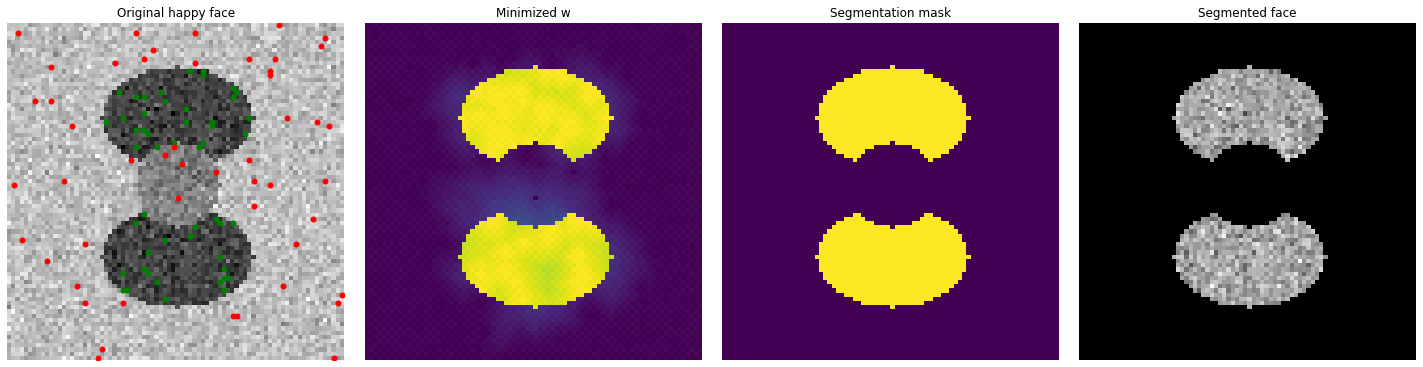

In [4]:
# ---------- 4. Visualize ----------
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(img_noisy, cmap='gray')
axs[0].set_title('Original happy face')
for pos in fg_seeds:
    axs[0].plot(pos[1], pos[0], 'go', markersize=5)
for pos in bg_seeds:
    axs[0].plot(pos[1], pos[0], 'ro', markersize=5)

axs[1].imshow(w_map1, cmap='viridis')
axs[1].set_title('Minimized w')

axs[2].imshow(seg1, cmap='viridis')
axs[2].set_title('Segmentation mask')

axs[3].imshow(img_noisy * seg1, cmap='gray')
axs[3].set_title('Segmented face')

for ax in axs:
    ax.axis('off')
plt.tight_layout()
plt.show()

Below we implment the offline adverserial image segmentation problem and solve it using the ZO-EG algorithm

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 1. Build synthetic image and seeds (your code)
# -------------------------------------------------------
H, W = 50, 50
img = np.ones((H, W)) * 120  # background

yy, xx = np.ogrid[:H, :W]

s = 50.0 / 80.0  # scaling factor

# scaled parameters
top_row = 22 * s
top_col = 40 * s
top_r_y = 12 * s
top_r_x = 18 * s

bot_row = 55 * s
bot_col = 40 * s
bot_r_y = 12 * s
bot_r_x = 18 * s

cen_row = 38 * s
cen_col = 40 * s
cen_r_y = 10 * s
cen_r_x = 10 * s

# top blob
mask_top = (yy - top_row)**2 / top_r_y**2 + (xx - top_col)**2 / top_r_x**2 <= 1
img[mask_top] = 60

# bottom blob
mask_bottom = (yy - bot_row)**2 / bot_r_y**2 + (xx - bot_col)**2 / bot_r_x**2 <= 1
img[mask_bottom] = 60

# center connector
mask_center = (yy - cen_row)**2 / cen_r_y**2 + (xx - cen_col)**2 / cen_r_x**2 <= 1
img[mask_center] = 90

# ---- choose seeds BEFORE noise ----
rng = np.random.default_rng()

coords_60 = np.argwhere(img == 60)
coords_90 = np.argwhere(img == 90)
coords_120 = np.argwhere(img == 120)

n_fg = 20
n_bg = 20
n_bg_90_min = 4

bg90_indices = rng.choice(len(coords_90), size=n_bg_90_min, replace=False)
bg_seeds_90 = coords_90[bg90_indices]

coords_bg_rest = np.vstack([coords_90, coords_120])
remaining = n_bg - n_bg_90_min

bg_rest_indices = rng.choice(len(coords_bg_rest), size=remaining, replace=False)
bg_seeds_rest = coords_bg_rest[bg_rest_indices]

fg_indices = rng.choice(len(coords_60), size=n_fg, replace=False)
# bg_indices = rng.choice(len(coords_90_120), size=n_bg, replace=False)

fg_seeds = [(int(r), int(c)) for r, c in coords_60[fg_indices]]
bg_seeds = [(int(r), int(c)) for r, c in np.vstack([bg_seeds_90, bg_seeds_rest])]


# ---- now add noise to the image ----
noise = np.random.normal(0, 10, (H, W))
img_noisy = np.clip(img + noise, 0, 255)

# -------------------------------------------------------
# 2. Graph, Lovász cut, and seed-trust model
# -------------------------------------------------------
height, width = H, W
n_pixels = height * width

sigma_I = 20.0    # intensity scale
sigma_x = 1.0     # spatial scale (1 pixel for neighbours)

edges = []

for i in range(height):
    for j in range(width):
        idx = i * width + j

        for di, dj in [(0,1), (1,0)]:  # 4-neighbours
            ni, nj = i + di, j + dj
            if ni < height and nj < width:
                jdx = ni * width + nj

                # spatial distance
                dist_sq = di**2 + dj**2

                # intensity distance
                diff_sq = (img_noisy[i, j] - img_noisy[ni, nj])**2

                # bilateral weight
                d = np.exp(
                    -dist_sq / (2 * sigma_x**2)
                    -diff_sq / (2 * sigma_I**2)
                )

                edges.append((idx, jdx, d))
                edges.append((jdx, idx, d))

edges = np.array(edges, dtype=float)  # shape (E,3)

# Lovász extension of the cut: f_cut(w) = sum_{(i,j)} d_ij * max(0, w_i - w_j)
def lovasz_cut_value(w):
    fr = edges[:, 0].astype(int)
    to = edges[:, 1].astype(int)
    d = edges[:, 2]
    x = w[fr] - w[to]
    return np.sum(d * np.maximum(x, 0.0))

def lovasz_cut_subgradient(w):
    fr = edges[:, 0].astype(int)
    to = edges[:, 1].astype(int)
    d = edges[:, 2]
    x = w[fr] - w[to]
    mask = x > 0
    g = np.zeros_like(w)
    # for edges where w_i - w_j > 0, subgrad wrt w_i += d, wrt w_j -= d
    np.add.at(g, fr[mask], d[mask])
    np.add.at(g, to[mask], -d[mask])
    return g

# seed information: flatten indices and labels
fg_flat = [r * width + c for (r, c) in fg_seeds]
bg_flat = [r * width + c for (r, c) in bg_seeds]
seeds_idx = np.array(fg_flat + bg_flat, dtype=int)
seeds_label = np.concatenate([
    np.ones(len(fg_flat)),   # foreground label 1
    np.zeros(len(bg_flat))   # background label 0
])
m = len(seeds_idx)          # number of seeds

lam = 5.0   # penalty strength

def seed_loss_value(w, y):
    # trust-weighted |w_p - label|
    w_seeds = w[seeds_idx]
    phi = lam * np.abs(w_seeds - seeds_label)
    return np.dot(y, phi)

def seed_loss_subgradient_w(w, y):
    g = np.zeros_like(w)
    w_seeds = w[seeds_idx]
    diff = w_seeds - seeds_label
    sign = np.sign(diff)     # subgradient of |.| ; sign(0) = 0 choice
    phi_grad = lam * y * sign
    np.add.at(g, seeds_idx, phi_grad)
    return g

def lovasz_value(w, y):
    return lovasz_cut_value(w) + seed_loss_value(w, y)

def lovasz_subgradient_fSy(_, y, __, w):
    # subgradient wrt w
    return lovasz_cut_subgradient(w) + seed_loss_subgradient_w(w, y)

# -------------------------------------------------------
# 3. Zeroth-order gradient for y and extragradient scheme
# -------------------------------------------------------
def g_mu_y_lovasz(w_fixed, y, mu=0.05, Y=20):
    m = len(y)
    gs = []
    for _ in range(Y):
        u = np.random.randn(m)
        f_plus = lovasz_value(w_fixed, y + mu * u)
        f0 = lovasz_value(w_fixed, y)
        g = (f_plus - f0) / mu
        gs.append(g * u)
    return np.mean(gs, axis=0)

def stepx(subg, x_curr, x_prev, y_curr, h):
    grd = subg(x_curr, y_curr)
    return x_prev - h * grd  # descent in w

def Projx(x):
    return np.clip(x, 0.0, 1.0)

def Projy(y, rho):
    y = np.clip(y, 0.0, 1.0)
    if y.sum() > rho:
        y = y * (rho / y.sum())  # project onto ℓ1 ball
    return y

def Projy_ball(y, rho):
    # project onto { y in [0,1]^m : sum y_i <= rho }
    y = np.clip(y, 0.0, 1.0)
    s = y.sum()
    if s <= rho:
        return y
    # Euclidean projection onto simplex {z >=0, sum z = rho}
    u = np.sort(y)[::-1]
    cssv = np.cumsum(u)
    j = np.nonzero(u * np.arange(1, len(u)+1) > (cssv - rho))[0][-1]
    theta = (cssv[j] - rho) / (j + 1.0)
    z = np.maximum(y - theta, 0.0)
    return np.minimum(z, 1.0)

def stepy_lovasz(w_curr, y_prev, y_curr, h, mu=0.05, Y=20):
    grd = g_mu_y_lovasz(w_curr, y_curr, mu, Y)
    return y_prev + h * grd      # ascent in y

def subg_wrapper(w, y):
    return lovasz_subgradient_fSy(None, y, None, w)

def ZO_minimax_robust(x0, y0, N, h=5e-3, mu=5e-2, Y=20, rho=30.0):
    p, m = len(x0), len(y0)
    x_hist = np.zeros((p, N+1))
    y_hist = np.zeros((m, N+1))
    x_hist[:, 0] = x0.copy()
    y_hist[:, 0] = y0.copy()
    for k in range(N):
        # extragradient first step
        x_tilde = Projx(stepx(subg_wrapper, x_hist[:, k], x_hist[:, k],
                              y_hist[:, k], h))
        y_tilde = Projy(stepy_lovasz(x_hist[:, k],
                                          y_hist[:, k], y_hist[:, k],
                                          h, mu, Y), rho)
        # second step
        x_hist[:, k+1] = Projx(stepx(subg_wrapper,x_tilde, x_hist[:, k], y_tilde, h))
        y_hist[:, k+1] = Projy(stepy_lovasz(x_tilde,
                                                 y_hist[:, k], y_tilde,
                                                 h, mu, Y), rho)
    return x_hist, y_hist




In [143]:
w0 = np.zeros(n_pixels)          # initial labeling (all 0)
y0 = np.ones(m) * 0.5            # initial trust weights

x_hist, y_hist = ZO_minimax_robust(w0, y0, N = 30000, h=1e-3, mu=1e-5, Y=20, rho=4.0)
w_final = x_hist[:, -1]
y_final = y_hist[:, -1]

def F_fSy(A_bin, y):
    # cut term
    val = 0.0
    for fr, to, d_val in edges:      # edges as (i,j,w)
        fr = int(fr); to = int(to)
        if (A_bin[fr] == 1) and (A_bin[to] == 0):
            val += d_val

    # seed term
    A_seeds = A_bin[seeds_idx]       # 0/1 for seeded pixels
    diff = np.abs(A_seeds - seeds_label)  # |A_p - label|
    val += np.dot(y, lam * diff)
    return val


w_best = x_hist[:, -1]      # minimiser (relaxed)
y_worst = y_hist[:, -1]     # maximiser (trust weights)
p = len(w_best)

def round_solution_fSy(w, y_fixed):
    p = len(w)
    order = np.argsort(-w)          # sort pixels by decreasing w
    best_val = np.inf
    best_set = None
    A_bin = np.zeros(p, dtype=int)

    for k in range(1, p+1):
        A_bin[:] = 0
        A_bin[order[:k]] = 1        # A = {top-k pixels by w}
        val = F_fSy(A_bin, y_fixed)
        if val < best_val:
            best_val = val
            best_set = A_bin.copy()
    return best_set, best_val

best_set, best_val = round_solution_fSy(w_best, y_worst)
seg1 = best_set.reshape((height, width)).astype(float)
w_map1 = w_best.reshape((height, width))


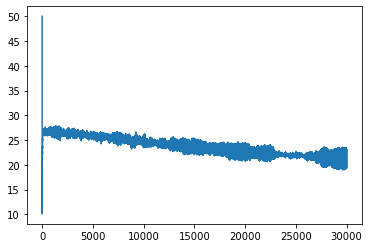

In [144]:
objective_history = [lovasz_value(x_hist[:, k], y_hist[:, k]) for k in range(30000+1)]
plt.plot(objective_history)

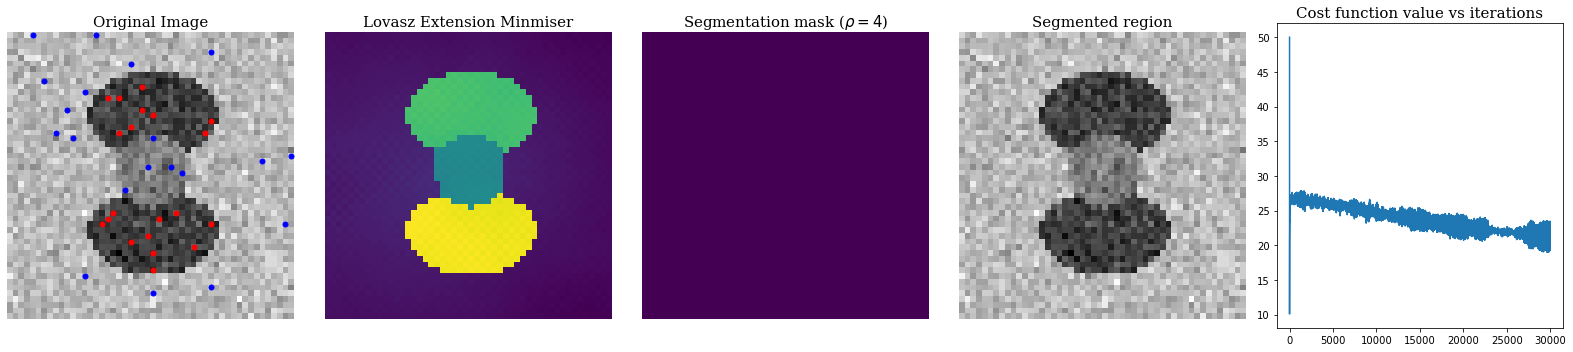

In [145]:
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 15}
fig, axs = plt.subplots(1, 5, figsize=(22, 5))


axs[0].imshow(img_noisy, cmap='gray')
axs[0].set_title('Original Image',fontdict=font)
for pos in fg_seeds:
    axs[0].plot(pos[1], pos[0], 'ro', markersize=5)
for pos in bg_seeds:
    axs[0].plot(pos[1], pos[0], 'bo', markersize=5)

axs[1].imshow(w_map1, cmap='viridis')
axs[1].set_title('Lovasz Extension Minmiser',fontdict=font)

axs[2].imshow(seg1, cmap='viridis')
axs[2].set_title(r'Segmentation mask ($\rho=4$)',fontdict=font)

axs[3].imshow(img_noisy * seg1, cmap='gray')
axs[3].set_title('Segmented region',fontdict=font)

axs[4].plot(objective_history)
axs[4].set_title('Cost function value vs iterations',fontdict=font)


for ax in axs[:4]:
    ax.set_axis_off()


fig.tight_layout()

for ax in axs[:4]:
    for im in ax.get_images():
        im.set_rasterized(True)
        
fig.savefig("dum4.png", dpi=300, bbox_inches="tight")


Below we implment the online adverserial image segmentation problem and solve it using the ZO-EG algorithm

In [147]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio

# -------------------------------------------------------
# 1. Global parameters and base dumbbell geometry
# -------------------------------------------------------
H, W = 50, 50

s = 50.0 / 80.0
top_row = 22 * s; top_col = 40 * s
top_r_y = 12 * s; top_r_x = 18 * s
bot_row = 55 * s; bot_col = 40 * s
bot_r_y = 12 * s; bot_r_x = 18 * s
cen_row = 38 * s; cen_col = 40 * s
cen_r_y = 10 * s; cen_r_x = 10 * s

# -------------------------------------------------------
# 2. Base image + seed selection (offline static)
# -------------------------------------------------------
def build_base_img_and_seeds(rng):
    img = np.ones((H, W)) * 120
    yy, xx = np.ogrid[:H, :W]

    # base dumbbell
    mask_top = (yy - top_row)**2 / top_r_y**2 + (xx - top_col)**2 / top_r_x**2 <= 1
    img[mask_top] = 60
    mask_bottom = (yy - bot_row)**2 / bot_r_y**2 + (xx - bot_col)**2 / bot_r_x**2 <= 1
    img[mask_bottom] = 60
    mask_center = (yy - cen_row)**2 / cen_r_y**2 + (xx - cen_col)**2 / cen_r_x**2 <= 1
    img[mask_center] = 90

    # seeds BEFORE noise (same logic as your offline code)
    coords_60 = np.argwhere(img == 60)
    coords_90 = np.argwhere(img == 90)
    coords_120 = np.argwhere(img == 120)

    n_fg = 50
    n_bg = 50
    n_bg_90_min = 10

    bg90_indices = rng.choice(len(coords_90), size=n_bg_90_min, replace=False)
    bg_seeds_90 = coords_90[bg90_indices]

    coords_bg_rest = np.vstack([coords_90, coords_120])
    remaining = n_bg - n_bg_90_min
    bg_rest_indices = rng.choice(len(coords_bg_rest), size=remaining, replace=False)
    bg_seeds_rest = coords_bg_rest[bg_rest_indices]

    fg_indices = rng.choice(len(coords_60), size=n_fg, replace=False)
    fg_seeds = [(int(r), int(c)) for r, c in coords_60[fg_indices]]
    bg_seeds = [(int(r), int(c)) for r, c in np.vstack([bg_seeds_90, bg_seeds_rest])]

    return img, np.array(fg_seeds, dtype=int), np.array(bg_seeds, dtype=int)

# -------------------------------------------------------
# 3. Transform image AND seeds together for frame t
#    (seeds are always kept same cardinality via clipping)
# -------------------------------------------------------
def transform_image_and_seeds(t, T_total, rng):
    """
    For frame index t in 0..T_total-1, return:
      - img_noisy_t: transformed, noisy image
      - fg_seeds_t, bg_seeds_t: NEW seeds sampled from this frame
        (always inside the correct regions).
    """
    # motion parameters
    tau = t / T_total
    angle_deg = 720 * tau              # 2 full rotations over the clip
    shift_row = 5 * np.sin(2 * np.pi * tau)
    shift_col = 5 * np.cos(2 * np.pi * 1.5 * tau)

    theta = np.deg2rad(angle_deg)
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    cy0, cx0 = cen_row, cen_col  # rotation center

    # transformed dumbbell (analytic)
    img = np.ones((H, W)) * 120
    yy, xx = np.indices((H, W))

    ellipses = [
        (top_row, top_col, top_r_y, top_r_x, 60),
        (bot_row, bot_col, bot_r_y, bot_r_x, 60),
        (cen_row, cen_col, cen_r_y, cen_r_x, 90),
    ]

    for cy, cx, ry, rx, val in ellipses:
        dy = cy - cy0
        dx = cx - cx0
        cy_r = cy0 + cos_t * dy - sin_t * dx + shift_row
        cx_r = cx0 + sin_t * dy + cos_t * dx + shift_col
        mask = ((yy - cy_r) ** 2) / (ry ** 2) + ((xx - cx_r) ** 2) / (rx ** 2) <= 1
        img[mask] = val

    # add noise
    noise = rng.normal(0, 10, (H, W))
    img_noisy = np.clip(img + noise, 0, 255)

    # ---- RESAMPLE SEEDS ON THIS FRAME ----
    coords_60 = np.argwhere(img == 60)   # foreground (rods)
    coords_90 = np.argwhere(img == 90)   # bridge
    coords_120 = np.argwhere(img == 120) # background

    n_fg = 50
    n_bg = 50
    n_bg_90_min = 10

    # foreground seeds: inside 60-valued regions
    fg_indices = rng.choice(len(coords_60), size=n_fg, replace=False)
    fg_seeds_t = coords_60[fg_indices]

    # background seeds: some on bridge (90), rest on 90/120
    bg90_indices = rng.choice(len(coords_90), size=n_bg_90_min, replace=False)
    bg_seeds_90 = coords_90[bg90_indices]

    coords_bg_rest = np.vstack([coords_90, coords_120])
    remaining = n_bg - n_bg_90_min
    bg_rest_indices = rng.choice(len(coords_bg_rest), size=remaining, replace=False)
    bg_seeds_rest = coords_bg_rest[bg_rest_indices]

    bg_seeds_t = np.vstack([bg_seeds_90, bg_seeds_rest])

    return img_noisy, fg_seeds_t.astype(int), bg_seeds_t.astype(int)

# -------------------------------------------------------
# 4. Lovász + seed loss model (unchanged core; shapes fixed)
# -------------------------------------------------------
sigma_I = 20.0
sigma_x = 1.0
lam = 10.0

edges = None
fg_flat = None
bg_flat = None
seeds_idx = None
seeds_label = None
m = None

def build_graph_and_seeds(img_noisy, fg_seeds, bg_seeds):
    global edges, fg_flat, bg_flat, seeds_idx, seeds_label, m
    height, width = img_noisy.shape
    edges_list = []
    for i in range(height):
        for j in range(width):
            idx = i * width + j
            for di, dj in [(0, 1), (1, 0)]:
                ni, nj = i + di, j + dj
                if ni < height and nj < width:
                    jdx = ni * width + nj
                    dist_sq = di**2 + dj**2
                    diff_sq = (img_noisy[i, j] - img_noisy[ni, nj])**2
                    d = np.exp(-dist_sq / (2 * sigma_x**2) - diff_sq / (2 * sigma_I**2))
                    edges_list.append((idx, jdx, d))
                    edges_list.append((jdx, idx, d))
    edges = np.array(edges_list, dtype=float)

    fg_flat = [int(r) * width + int(c) for (r, c) in fg_seeds]
    bg_flat = [int(r) * width + int(c) for (r, c) in bg_seeds]
    seeds_idx = np.array(fg_flat + bg_flat, dtype=int)
    seeds_label = np.concatenate([
        np.ones(len(fg_flat)),
        np.zeros(len(bg_flat)),
    ])
    m = len(seeds_idx)
    return height * width

def lovasz_cut_value(w):
    fr = edges[:, 0].astype(int)
    to = edges[:, 1].astype(int)
    d = edges[:, 2]
    x = w[fr] - w[to]
    return np.sum(d * np.maximum(x, 0.0))

def lovasz_cut_subgradient(w):
    fr = edges[:, 0].astype(int)
    to = edges[:, 1].astype(int)
    d = edges[:, 2]
    x = w[fr] - w[to]
    mask = x > 0
    g = np.zeros_like(w)
    np.add.at(g, fr[mask], d[mask])
    np.add.at(g, to[mask], -d[mask])
    return g

def seed_loss_value(w, y):
    w_seeds = w[seeds_idx]
    phi = lam * np.abs(w_seeds - seeds_label)
    return np.dot(y, phi)

def seed_loss_subgradient_w(w, y):
    g = np.zeros_like(w)
    w_seeds = w[seeds_idx]
    diff = w_seeds - seeds_label
    sign = np.sign(diff)
    phi_grad = lam * y * sign
    np.add.at(g, seeds_idx, phi_grad)
    return g

def lovasz_value(w, y):
    return lovasz_cut_value(w) + seed_loss_value(w, y)

def lovasz_subgradient_fSy(_, y, __, w):
    return lovasz_cut_subgradient(w) + seed_loss_subgradient_w(w, y)

def g_mu_y_lovasz(w_fixed, y, mu=0.05, Y=20):
    mloc = len(y)
    gs = []
    for _ in range(Y):
        u = np.random.randn(mloc)
        f_plus = lovasz_value(w_fixed, y + mu * u)
        f0 = lovasz_value(w_fixed, y)
        g = (f_plus - f0) / mu
        gs.append(g * u)
    return np.mean(gs, axis=0)

def stepx(subg, x_curr, x_prev, y_curr, h):
    grd = subg(x_curr, y_curr)
    return x_prev - h * grd  # descent in w

def Projx(x):
    return np.clip(x, 0.0, 1.0)

def Projy(y, rho):
    y = np.clip(y, 0.0, 1.0)
    if y.sum() > rho:
        y = y * (rho / y.sum())
    return y

def Projy_ball(y, rho):
    y = np.clip(y, 0.0, 1.0)
    s = y.sum()
    if s <= rho:
        return y
    u = np.sort(y)[::-1]
    cssv = np.cumsum(u)
    j = np.nonzero(u * np.arange(1, len(u) + 1) > (cssv - rho))[0][-1]
    theta = (cssv[j] - rho) / (j + 1.0)
    z = np.maximum(y - theta, 0.0)
    return np.minimum(z, 1.0)

def stepy_lovasz(w_curr, y_prev, y_curr, h, mu=0.05, Y=20):
    grd = g_mu_y_lovasz(w_curr, y_curr, mu, Y)
    return y_prev + h * grd  # ascent in y

def subg_wrapper(w, y):
    return lovasz_subgradient_fSy(None, y, None, w)

def F_fSy(A_bin, y):
    val = 0.0
    for fr, to, d_val in edges:
        fr = int(fr); to = int(to)
        if (A_bin[fr] == 1) and (A_bin[to] == 0):
            val += d_val
    A_seeds = A_bin[seeds_idx]
    diff = np.abs(A_seeds - seeds_label)
    val += np.dot(y, lam * diff)
    return val

def round_solution_fSy(w, y_fixed):
    p = len(w)
    order = np.argsort(-w)
    best_val = np.inf
    best_set = None
    A_bin = np.zeros(p, dtype=int)
    ks = np.linspace(1, p, min(p, 100), dtype=int)
    for k in ks:
        A_bin[:] = 0
        A_bin[order[:k]] = 1
        val = F_fSy(A_bin, y_fixed)
        if val < best_val:
            best_val = val
            best_set = A_bin.copy()
    return best_set, best_val

# -------------------------------------------------------
# 5. Online loop: one extragradient step per frame
# -------------------------------------------------------
rng = np.random.default_rng()
img_base, fg_seeds_base, bg_seeds_base = build_base_img_and_seeds(rng)


fps = 60
T_sec = 180       
n_frames = fps * T_sec

# initialise with frame 0 to get dimensions
img0, fg0, bg0 = transform_image_and_seeds(0, n_frames, rng)
n_pixels = H * W
build_graph_and_seeds(img0, fg0, bg0)


2500

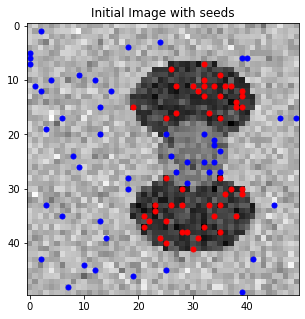

In [148]:
plt.figure(figsize=(5, 5))
plt.imshow(img0, cmap='gray')
plt.title('Initial Image with seeds')
for pos in fg0:
    plt.plot(pos[1], pos[0], 'ro', markersize=5)
for pos in bg0:
    plt.plot(pos[1], pos[0], 'bo', markersize=5)

In [149]:
w = np.zeros(n_pixels)
y = np.ones(m) * 0.5    # m is fixed and matches seeds_idx length

h = 3e-2
mu = 1e-3
Y = 10
rho = 25.0

orig_video = []
wmap_video = []
seg_video = []
w_t = []
y_t = []
w_t.append(w)
y_t.append(y)

for t in range(n_frames):
    img_noisy, fg_t, bg_t = transform_image_and_seeds(t, n_frames, rng)

    # rebuild graph and seeds each frame
    build_graph_and_seeds(img_noisy, fg_t, bg_t)

    # one extragradient iteration
    x_prev = w.copy()
    y_prev = y.copy()

    x_tilde = Projx(stepx(subg_wrapper, x_prev, x_prev, y_prev, h))
    y_tilde = Projy(stepy_lovasz(x_prev, y_prev, y_prev, h, mu, Y), rho)

    x_next = Projx(stepx(subg_wrapper, x_tilde, x_prev, y_tilde, h))
    y_next = Projy(stepy_lovasz(x_tilde, y_prev, y_tilde, h, mu, Y), rho)

    w = x_next
    y = y_next

    w_t.append(w)
    y_t.append(y)

    w_map = w.reshape((H, W))
    # best_set, _ = round_solution_fSy(w, y)
    # seg = best_set.reshape((H, W)).astype(float)

    # taue = np.median(w_map)
    taue = 0.5  
    seg = (w_map >= taue).astype(float)

    orig_video.append(img_noisy)
    wmap_video.append(w_map)
    seg_video.append(img_noisy * seg)

# -------------------------------------------------------
# 6. Build side-by-side RGB frames and save video with imageio
# -------------------------------------------------------
def make_rgb(x, cmap='gray', vmin=None, vmax=None):
    import matplotlib.pyplot as plt
    x = np.asarray(x)
    if vmin is None:
        vmin = float(x.min())
    if vmax is None:
        vmax = float(x.max())
    x_norm = (x - vmin) / (vmax - vmin + 1e-12)
    cmap_fn = plt.get_cmap(cmap)
    rgba = cmap_fn(x_norm)
    rgb = (rgba[..., :3] * 255).astype(np.uint8)
    return rgb

frames_out = []
for t in range(n_frames):
    im_orig_rgb = make_rgb(orig_video[t], cmap='gray', vmin=0, vmax=255)
    im_wmap_rgb = make_rgb(wmap_video[t], cmap='viridis')
    im_seg_rgb  = make_rgb(seg_video[t],  cmap='gray', vmin=0, vmax=255)

    frame_rgb = np.concatenate([im_orig_rgb, im_wmap_rgb, im_seg_rgb], axis=1)
    frames_out.append(frame_rgb)

output_path = "online_dumbbell_segmentation_imageio.mp4"
with imageio.get_writer(output_path, fps=fps) as writer:
    for frame in frames_out:
        writer.append_data(frame)

print("Saved video to:", output_path)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (150, 50) to (160, 64) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Saved video to: online_dumbbell_segmentation_imageio.mp4


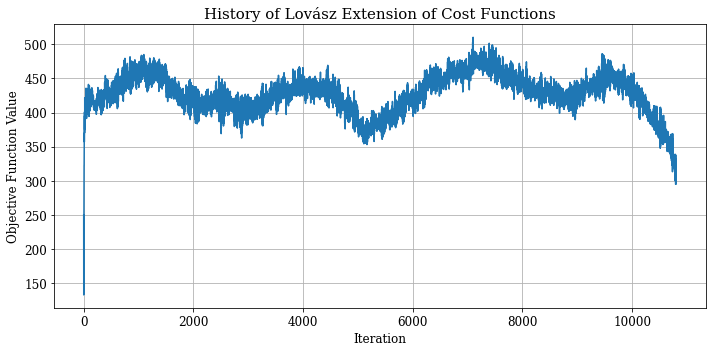

In [158]:
objective_history = [lovasz_value(w_t[k], y_t[k]) for k in range(n_frames)]
font = {'family': 'serif', 'color':  'black', 'weight': 'normal', 'size': 15}
font1 = {'family': 'serif', 'size': 12}
plt.figure(figsize=(10, 5))
plt.xticks(fontname='serif', fontsize=12, color='black')
plt.yticks(fontname='serif', fontsize=12, color='black')
plt.plot(np.arange(0, n_frames, 1), objective_history, label="Robust Objective (online)")
plt.xlabel("Iteration", fontdict=font1)
plt.ylabel("Objective Function Value", fontdict=font1)
plt.title(f'History of Lovász Extension of Cost Functions',fontdict=font)
plt.grid(True)
plt.tight_layout()
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42   # Embed TrueType fonts
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['text.usetex'] = False
plt.savefig('fvalon2.pdf', dpi=300, transparent=False, bbox_inches='tight')

In [159]:
w_final = w_t[n_frames//2]
y_final = y_t[n_frames//2]

img_noisy, fg_t, bg_t = transform_image_and_seeds(n_frames//2, n_frames, rng)

w_mapf = w_final.reshape((H, W))
best_set, _ = round_solution_fSy(w_final, y_final)
seg0 = best_set.reshape((H, W)).astype(float)

taue1 = np.median(w_mapf)
taue2 = 0.5  
seg1 = (w_mapf >= taue1).astype(float)
seg2 = (w_mapf >= taue2).astype(float)



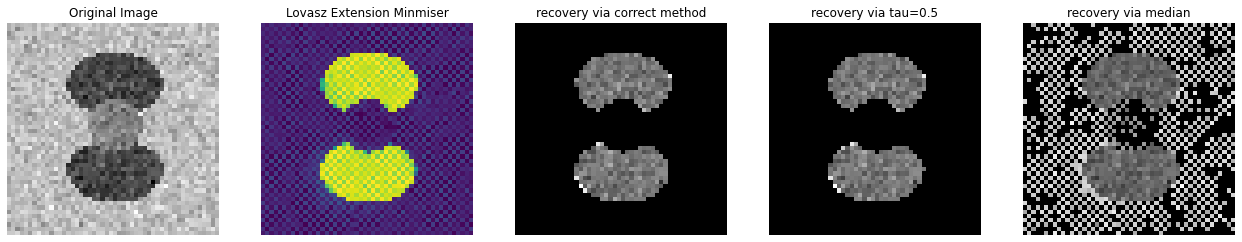

In [160]:
fig, axs = plt.subplots(1, 5, figsize=(22, 5))


axs[0].imshow(img_noisy, cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(w_mapf, cmap='viridis')
axs[1].set_title('Lovasz Extension Minmiser')

axs[2].imshow(img_noisy * seg0, cmap='gray')
axs[2].set_title('recovery via correct method')

axs[3].imshow(img_noisy * seg2, cmap='gray')
axs[3].set_title('recovery via tau=0.5')

axs[4].imshow(img_noisy * seg1, cmap='gray')
axs[4].set_title('recovery via median')


for ax in axs[:5]:
    ax.set_axis_off()


# fig.tight_layout()

# for ax in axs[:4]:
#     for im in ax.get_images():
#         im.set_rasterized(True)
        
# fig.savefig("dum4.png", dpi=300, bbox_inches="tight")

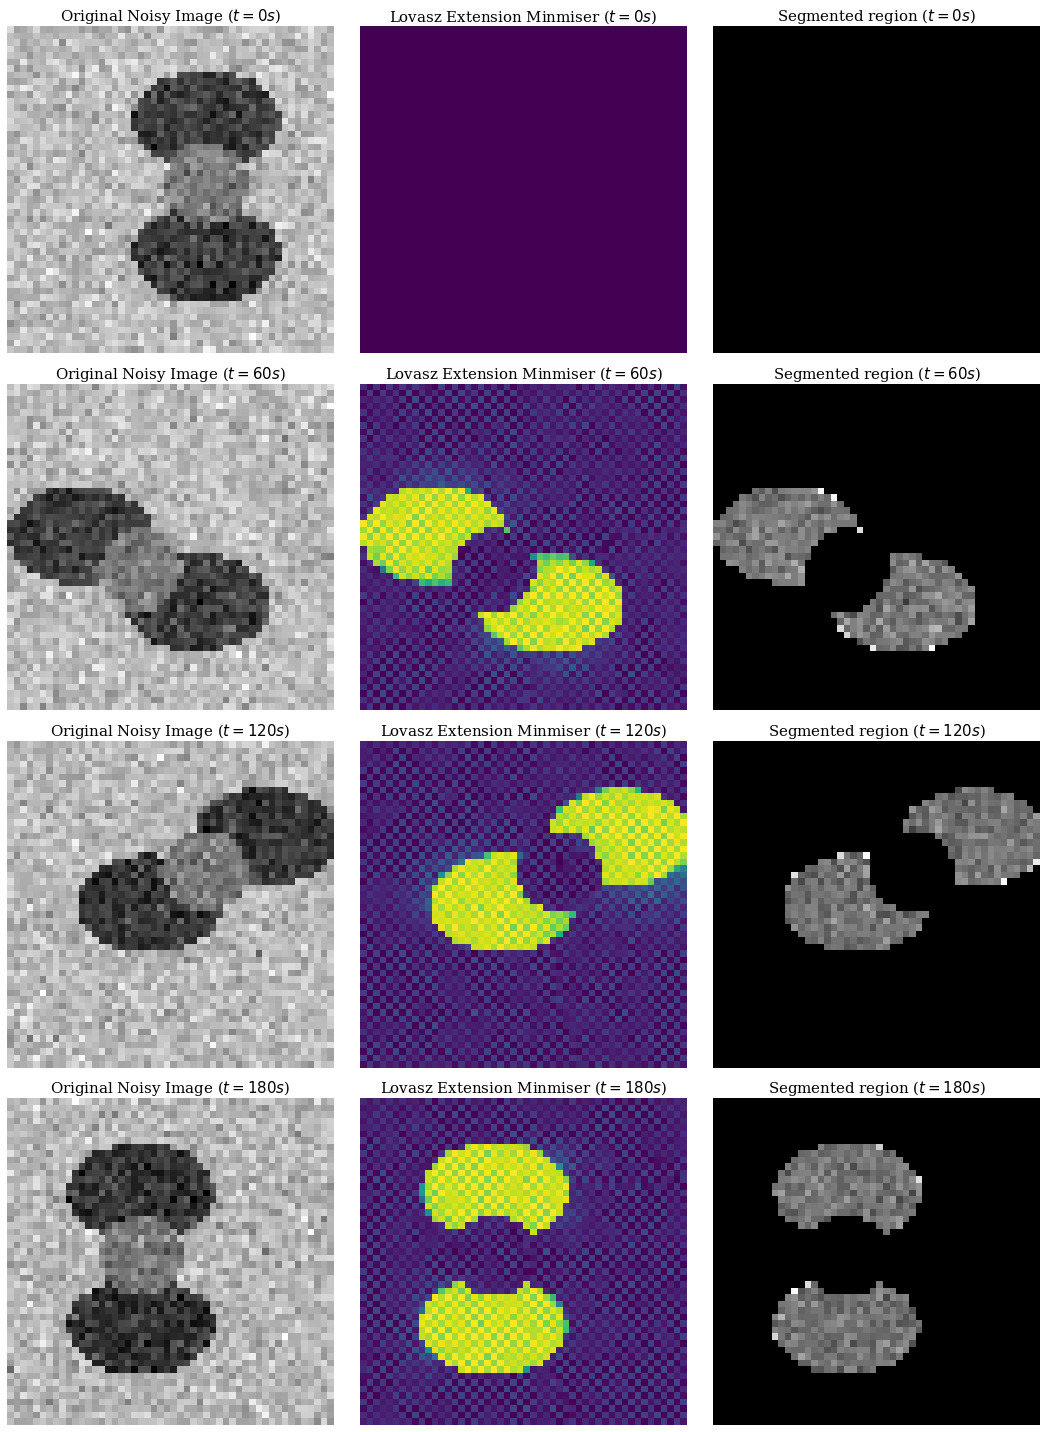

In [161]:
w_00 = w_t[0]
y_00 = y_t[0]

w_60 = w_t[n_frames//3]
y_60 = y_t[n_frames//3]

w_120 = w_t[2*n_frames//3]
y_120 = y_t[2*n_frames//3]

w_final = w_t[-1]
y_final = y_t[-1]

img_noisy00, fg_t00, bg_t00 = transform_image_and_seeds(0, n_frames , rng)
img_noisy60, fg_t60, bg_t60 = transform_image_and_seeds(n_frames//3, n_frames, rng)
img_noisy120, fg_t120, bg_t120 = transform_image_and_seeds(2*n_frames//3, n_frames, rng)
img_noisy_final, fg_t_final, bg_t_final = transform_image_and_seeds(n_frames-1, n_frames, rng)

w_map00 = w_00.reshape((H, W))
w_map60 = w_60.reshape((H, W))
w_map120 = w_120.reshape((H, W))
w_map_final = w_final.reshape((H, W))

taue = 0.5  

seg00 = (w_map00 >= taue).astype(float)
seg60 = (w_map60 >= taue).astype(float)
seg120 = (w_map120 >= taue).astype(float)
seg_final = (w_map_final >= taue).astype(float)


fig, axs = plt.subplots(4, 3, figsize=(15, 20))

axs[0][0].imshow(img_noisy00, cmap='gray')
axs[0][0].set_title(r'Original Noisy Image ($t=0s$)',fontdict=font)
# for pos in fg_t00:
#     axs[0][0].plot(pos[1], pos[0], 'ro', markersize=5)
# for pos in bg_t00:
#     axs[0][0].plot(pos[1], pos[0], 'bo', markersize=5)
axs[0][1].imshow(w_map00, cmap='viridis')
axs[0][1].set_title(r'Lovasz Extension Minmiser ($t=0s$)',fontdict=font)
axs[0][2].imshow(img_noisy00 * seg00, cmap='gray')
axs[0][2].set_title(r'Segmented region ($t=0s$)',fontdict=font)

axs[1][0].imshow(img_noisy60, cmap='gray')
axs[1][0].set_title(r'Original Noisy Image ($t=60s$)',fontdict=font)
# for pos in fg_t60:
#     axs[1][0].plot(pos[1], pos[0], 'ro', markersize=5)
# for pos in bg_t60:
#     axs[1][0].plot(pos[1], pos[0], 'bo', markersize=5)
axs[1][1].imshow(w_map60, cmap='viridis')
axs[1][1].set_title(r'Lovasz Extension Minmiser ($t=60s$)',fontdict=font)
axs[1][2].imshow(img_noisy60 * seg60, cmap='gray')
axs[1][2].set_title(r'Segmented region ($t=60s$)',fontdict=font)

axs[2][0].imshow(img_noisy120, cmap='gray')
axs[2][0].set_title(r'Original Noisy Image ($t=120s$)',fontdict=font)
# for pos in fg_t120:
#     axs[2][0].plot(pos[1], pos[0], 'ro', markersize=5)
# for pos in bg_t120:
#     axs[2][0].plot(pos[1], pos[0], 'bo', markersize=5)
axs[2][1].imshow(w_map120, cmap='viridis')
axs[2][1].set_title(r'Lovasz Extension Minmiser ($t=120s$)',fontdict=font)
axs[2][2].imshow(img_noisy120 * seg120, cmap='gray')
axs[2][2].set_title(r'Segmented region ($t=120s$)',fontdict=font)

axs[3][0].imshow(img_noisy_final, cmap='gray')
axs[3][0].set_title(r'Original Noisy Image ($t=180s$)',fontdict=font)
# for pos in fg_t_final:
#     axs[3][0].plot(pos[1], pos[0], 'ro', markersize=5)
# for pos in bg_t_final:
#     axs[3][0].plot(pos[1], pos[0], 'bo', markersize=5)
axs[3][1].imshow(w_map_final, cmap='viridis')
axs[3][1].set_title(r'Lovasz Extension Minmiser ($t=180s$)',fontdict=font)
axs[3][2].imshow(img_noisy_final * seg_final, cmap='gray')
axs[3][2].set_title(r'Segmented region ($t=180s$)',fontdict=font)

for ax in axs.flat:
    ax.set_axis_off()

fig.tight_layout()
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['text.usetex'] = False
plt.savefig('clusteron2.pdf', dpi=300, transparent=False, bbox_inches='tight')

In [162]:
def compute_iou(mask_pred, mask_gt):
    """
    Compute IoU between predicted mask and ground-truth mask.
    mask_pred, mask_gt: np.array of 0/1, same shape
    """
    mask_pred = mask_pred.astype(bool)
    mask_gt = mask_gt.astype(bool)
    
    intersection = np.logical_and(mask_pred, mask_gt).sum()
    union = np.logical_or(mask_pred, mask_gt).sum()
    
    if union == 0:
        return 1.0  # both empty → perfect match
    return intersection / union

fps = 60
T_sec = 180
n_frames = fps * T_sec

gt_video = []       # ground truth masks (0/1)
gt_video_orig = []  # noisy images

rng = np.random.default_rng()

# center of rotation
cy0, cx0 = cen_row, cen_col

yy, xx = np.indices((H, W))

for t in range(n_frames):
    tau = t / n_frames
    angle_deg = 720 * tau
    shift_row = 5 * np.sin(2 * np.pi * tau)
    shift_col = 5 * np.cos(2 * np.pi * 1.5 * tau)

    theta = np.deg2rad(angle_deg)
    cos_t, sin_t = np.cos(theta), np.sin(theta)

    # full dumbbell image (no noise)
    img = np.ones((H, W)) * 120

    ellipses = [
        (top_row, top_col, top_r_y, top_r_x, 60),
        (bot_row, bot_col, bot_r_y, bot_r_x, 60),
        (cen_row, cen_col, cen_r_y, cen_r_x, 90),
    ]

    for cy, cx, ry, rx, val in ellipses:
        dy = cy - cy0
        dx = cx - cx0
        cy_r = cy0 + cos_t * dy - sin_t * dx + shift_row
        cx_r = cx0 + sin_t * dy + cos_t * dx + shift_col
        mask = ((yy - cy_r) ** 2) / (ry ** 2) + ((xx - cx_r) ** 2) / (rx ** 2) <= 1
        img[mask] = val

    # GT mask: pixels exactly with value 60
    mask_gt = (img == 60).astype(np.float32)

    # noisy image for visualization or NN input
    img_noisy = np.clip(img + rng.normal(0, 10, (H, W)), 0, 255)

    gt_video.append(mask_gt)
    gt_video_orig.append(img_noisy)





# Now compute IoU per frame for NN
iou_nn = [compute_iou(pred, gt) for pred, gt in zip(seg_video[120:-1], gt_video[120:-1])]
mean_iou_nn = np.mean(iou_nn)

# # Compute IoU per frame for your algorithm
# iou_algo = [compute_iou(pred, gt) for pred, gt in zip(algo_seg_video, gt_video)]
# mean_iou_algo = np.mean(iou_algo)

print(f"Mean IoU over video: NN = {mean_iou_nn:.4f}")

Mean IoU over video: NN = 0.9750


In [163]:
def img_mask_to_uint8(img, mask):
    out = img * mask
    out = np.clip(out, 0, 255)
    return out.astype(np.uint8)

with imageio.get_writer("zoeg_gt.mp4", fps=fps) as writer:
    for img, mask in zip(gt_video_orig, gt_video):  
        frame = img_mask_to_uint8(img, mask)
        writer.append_data(frame)


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (50, 50) to (64, 64) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [164]:
def compute_prf(mask_pred, mask_gt, eps=1e-8):
    """
    Compute precision, recall, F1 for a single binary mask.
    mask_pred, mask_gt: np.ndarray of shape (H,W), values 0/1
    """
    mask_pred = mask_pred.astype(bool)
    mask_gt = mask_gt.astype(bool)

    tp = np.logical_and(mask_pred, mask_gt).sum()
    fp = np.logical_and(mask_pred, np.logical_not(mask_gt)).sum()
    fn = np.logical_and(np.logical_not(mask_pred), mask_gt).sum()

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    return precision, recall, f1

# Lists to store per-frame metrics
precisions, recalls, f1s = [], [], []

# Loop over frames
for pred, gt in zip(seg_video[120:-1], gt_video[120:-1]):
    p, r, f = compute_prf(pred, gt)
    precisions.append(p)
    recalls.append(r)
    f1s.append(f)

# Average over the video
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)
mean_f1 = np.mean(f1s)

print(f"Video Precision: {mean_precision:.4f}")
print(f"Video Recall:    {mean_recall:.4f}")
print(f"Video F1 score:  {mean_f1:.4f}")


Video Precision: 0.9859
Video Recall:    0.9888
Video F1 score:  0.9873


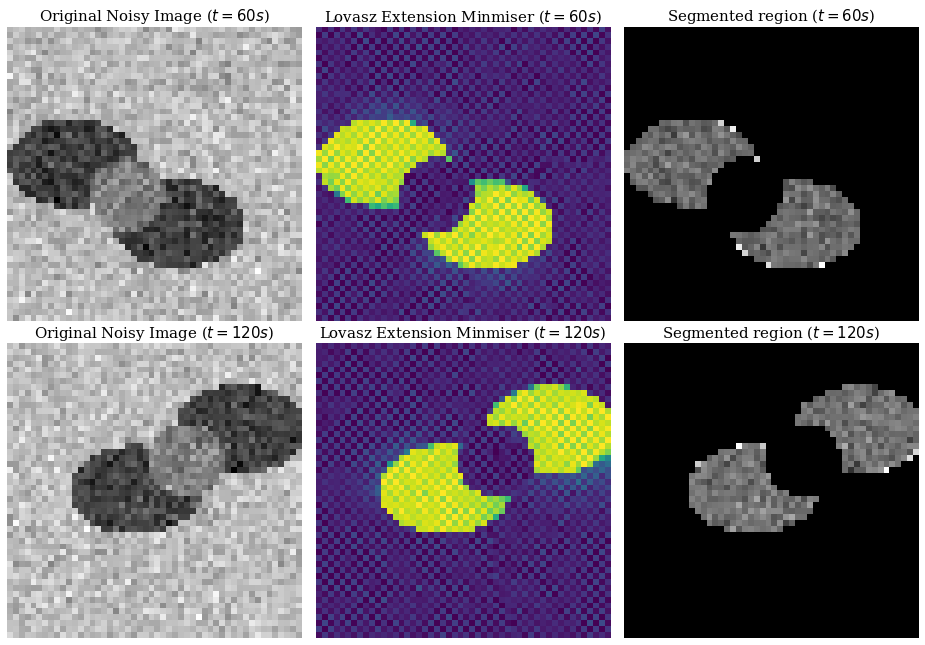

In [169]:
w_00 = w_t[0]
y_00 = y_t[0]

w_60 = w_t[n_frames//3]
y_60 = y_t[n_frames//3]

w_120 = w_t[2*n_frames//3]
y_120 = y_t[2*n_frames//3]

w_final = w_t[-1]
y_final = y_t[-1]

img_noisy00, fg_t00, bg_t00 = transform_image_and_seeds(0, n_frames , rng)
img_noisy60, fg_t60, bg_t60 = transform_image_and_seeds(n_frames//3, n_frames, rng)
img_noisy120, fg_t120, bg_t120 = transform_image_and_seeds(2*n_frames//3, n_frames, rng)
img_noisy_final, fg_t_final, bg_t_final = transform_image_and_seeds(n_frames-1, n_frames, rng)

w_map00 = w_00.reshape((H, W))
w_map60 = w_60.reshape((H, W))
w_map120 = w_120.reshape((H, W))
w_map_final = w_final.reshape((H, W))

taue = 0.5  

seg00 = (w_map00 >= taue).astype(float)
seg60 = (w_map60 >= taue).astype(float)
seg120 = (w_map120 >= taue).astype(float)
seg_final = (w_map_final >= taue).astype(float)


fig, axs = plt.subplots(2, 3, figsize=(13, 9))

axs[0][0].imshow(img_noisy60, cmap='gray')
axs[0][0].set_title(r'Original Noisy Image ($t=60s$)',fontdict=font)
# for pos in fg_t60:
#     axs[1][0].plot(pos[1], pos[0], 'ro', markersize=5)
# for pos in bg_t60:
#     axs[1][0].plot(pos[1], pos[0], 'bo', markersize=5)
axs[0][1].imshow(w_map60, cmap='viridis')
axs[0][1].set_title(r'Lovasz Extension Minmiser ($t=60s$)',fontdict=font)
axs[0][2].imshow(img_noisy60 * seg60, cmap='gray')
axs[0][2].set_title(r'Segmented region ($t=60s$)',fontdict=font)

axs[1][0].imshow(img_noisy120, cmap='gray')
axs[1][0].set_title(r'Original Noisy Image ($t=120s$)',fontdict=font)
# for pos in fg_t120:
#     axs[2][0].plot(pos[1], pos[0], 'ro', markersize=5)
# for pos in bg_t120:
#     axs[2][0].plot(pos[1], pos[0], 'bo', markersize=5)
axs[1][1].imshow(w_map120, cmap='viridis')
axs[1][1].set_title(r'Lovasz Extension Minmiser ($t=120s$)',fontdict=font)
axs[1][2].imshow(img_noisy120 * seg120, cmap='gray')
axs[1][2].set_title(r'Segmented region ($t=120s$)',fontdict=font)


for ax in axs.flat:
    ax.set_axis_off()

fig.tight_layout()
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['text.usetex'] = False
plt.savefig('clusteron3.pdf', dpi=300, transparent=False, bbox_inches='tight')